</p>
<p>-adding custom schedule [improved learning]</p>
<p>-adjusting hyperparameters, d_model =100, droprate =  0.2</p>

<p>-extracted pre-training word embeddings/post embedding weights to output for viz </p>
<p>-updated Transformer, Encoding and Positional Encoding classes to be able to load pre-trained Embeddings</p>

<p>-Adding Learnable Positional encoding</p>
<p>-Adding FastText Embeddings</p>
<p>-adding attention weights to output for viz </p>

<style>
td {
  text-align: center;
}

th {
  text-align: center;
}
</style>

## Setup

The following codes ensures the words embeddings have the same result after being randomly initialized

In [ ]:
import tensorflow as tf
import numpy as np

# Set the seed for random number generation
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)



In [ ]:

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Navigate to the Directory Containing the CSV File
import os
os.chdir('/content/drive/My Drive/DS266 Project')

Begin by installing [TensorFlow Datasets](https://tensorflow.org/datasets) for loading the dataset and [TensorFlow Text](https://www.tensorflow.org/text) for text preprocessing:

In [ ]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2 -q
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text -q
!pip install -q protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Reading package lists...
Building dependency tree...
Reading state information...
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Version '8.1.0.77-1+cuda11.2' for 'libcudnn8' was not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 103.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 96.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 108.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 34.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This b

In [ ]:
# Install compatible TensorFlow version
!pip uninstall tensorflow -y -q
!pip install tensorflow==2.15 -q

# Reinstall tf-keras to resolve any potential dependency conflicts
!pip uninstall tf-keras -y -q
!pip install tf-keras -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 78.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.16.1 requires tensorflow<2.17,>=2.16.1; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.15.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.1 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow==2.15 -q #it needs it again for some reason

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.16.1 requires tensorflow<2.17,>=2.16.1; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.15.0 which is incompatible.
tf-keras 2.16.0 requires tensorflow<2.17,>=2.16, but you have tensorflow 2.15.0 which is incompatible.


In [ ]:
!pip uninstall tensorflow-text -y -q
!pip install tensorflow-text==2.15 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 80.4 MB/s eta 0:00:00


Import the necessary modules:

In [ ]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text as text
from tensorflow import keras

## Data handling



### Download the dataset

read the data

In [ ]:
# Read the CSV File
import pandas as pd
load_data = 'train_enhanced_cleaned.csv'
tweets_df = pd.read_csv(load_data)
tweets_df.head(3)

,text,target
0,location our deeds are the reason of this ea...,1
1,location forest fire near la ronge sask can...,1
2,location all residents asked to shelter in p...,1


### Set up the tokenizer

Now that you have loaded the dataset, you need to tokenize the text, so that each element is represented as a [token](https://developers.google.com/machine-learning/glossary#token) or token ID (a numeric representation).

Tokenization is the process of breaking up text, into "tokens". Depending on the tokenizer, these tokens can represent sentence-pieces, words, subwords, or characters. To learn more about tokenization, visit [this guide](https://www.tensorflow.org/text/guide/tokenizers).

In [ ]:
sentences = tweets_df['text']
labels = tweets_df['target']

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Instantiate the tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on your text data
tokenizer.fit_on_texts(sentences)


In [ ]:
MAX_TOKENS =30
# Convert sentences to sequences
sequences = tokenizer.texts_to_sequences(sentences)

# Pad sequences
sequences = pad_sequences(sequences, maxlen=MAX_TOKENS, padding='post')

# Convert labels to NumPy array
"""

"""

'\n\n'

### Set up a data pipeline with `tf.data`

The following function takes batches of text as input, and converts them to a format suitable for training.

1. It tokenizes them into ragged batches.
2. It trims each to be no longer than `MAX_TOKENS`.
3. It splits the target (English) tokens into inputs and labels. These are shifted by one step so that at each input location the `label` is the id of the next token.
4. It converts the `RaggedTensor`s to padded dense `Tensor`s.
5. It returns an `(inputs, labels)` pair.


In [ ]:
from sklearn.model_selection import train_test_split
# Shuffle and batch the dataset
BUFFER_SIZE = len(sequences)
BATCH_SIZE = 64  # You can adjust the batch size as needed

# Split the data
sequences_train, sequences_val, labels_train, labels_val = train_test_split(sequences, labels, test_size=0.1)

# Convert to TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((sequences_train, labels_train))
val_dataset = tf.data.Dataset.from_tensor_slices((sequences_val, labels_val))

# Shuffle and batch the datasets
train_dataset = train_dataset.shuffle(len(sequences_train)).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)




In [ ]:
#train_dataset.append()

### Test the Dataset

In [ ]:
# For train_batches
for x, y in train_dataset.take(1):  # We only take one batch
    print("Shape of X:", x.shape)
    print("Data type of X:", x.dtype)  # This will print the data type
    print("Content of X:", x.numpy())  # .numpy() converts the tensor to a numpy array
    print("Shape of Y:", y.shape)
    print("Content of Y:", y.numpy())

# For val_batches
for x, y in val_dataset.take(1):  # We only take one batch
    print("Shape of X:", x.shape)
    print("Data type of X:", x.dtype)  # This will print the data type
    print("Content of X:", x.numpy())  # .numpy() converts the tensor to a numpy array
    print("Shape of Y:", y.shape)
    print("Content of Y:", y.numpy())

Shape of X: (64, 30)
Data type of X: <dtype: 'int32'>
Content of X: [[    4   253     9 ...     0     0     0]
 [    4    42  6141 ...     0     0     0]
 [    4   301  1461 ...     0     0     0]
 ...
 [    4   321 11338 ...     6     5    18]
 [    4   283   238 ...     0     0     0]
 [  136    66   328 ...     6     5    15]]
Shape of Y: (64,)
Content of Y: [1 0 0 1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1
 1 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 1 0]
Shape of X: (64, 30)
Data type of X: <dtype: 'int32'>
Content of X: [[    4   259    48 ...     0     0     0]
 [    4   216     9 ...     5    22     0]
 [    4    91 15093 ...     0     0     0]
 ...
 [    4   367     2 ...     0     0     0]
 [    4   256   179 ...     0     0     0]
 [    4   105   392 ...     0     0     0]]
Shape of Y: (64,)
Content of Y: [1 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0 0 0 1 1 0 1
 0 0 0 0 1 0 1 0 1 1 0 1 1 0 1 1 0 0 0 1 0 1 0 0 0 1 0]


In [ ]:
for tweet, labels in train_dataset.take(1):
  break

print(tweet.shape)
print(labels.shape)


(64, 30)
(64,)


##Location of Saved Training

Save the models, and files, if directory does not exist, it creates it.

In [ ]:

checkpoint_dir = './Final_Work/enh_cl_data_lp_tx_model_tw_emb_12ep_d06_dff_256/'
directory = checkpoint_dir

if not os.path.exists(directory):
    os.makedirs(directory)


 </section>

## Define the components

### The Transformer Classifier with Learnable Positional Encoding

This model is based on last hidden state

In [ ]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)



# PositionalEmbedding with trainable positional encodings
class PositionalEmbedding(tf.keras.layers.Layer):
    """Custom Keras layer that integrates trainable positional encodings with token embeddings.

      This layer first creates an embedding matrix for the vocabulary and then adds trainable positional
      encodings to the token embeddings. The idea is to allow the model to learn the optimal positional
      encodings along with learning the token embeddings, which could provide more flexibility and
      potentially better performance for certain datasets or problems.

      Args:
          vocab_size (int): Size of the vocabulary. This determines the number of rows in the embedding matrix.
          d_model (int): The dimensionality of the embeddings. Each token is transformed into a vector of this size.
          maxlen (int): The maximum length of input sequences this embedding layer will be used with. This defines
                        the size of the positional encoding matrix, ensuring it can handle sequences up to this length.

      Attributes:
          d_model (int): Stored dimensionality of the embeddings, used for scaling the embeddings.
          embedding (tf.keras.layers.Embedding): The embedding layer that transforms token indices into embeddings.
          pos_encoding (tf.Variable): Trainable positional encodings added to token embeddings. Initialized with
                                      random values and learned during training.    """


    def __init__(self, vocab_size, d_model, maxlen=2048, pretrained_embeddings=None):
        super(PositionalEmbedding, self).__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = self.add_weight("pos_encoding", shape=[maxlen, d_model], initializer="random_normal", trainable=True)

        # If pretrained embeddings are provided, set the weights of the embedding layer
        if pretrained_embeddings is not None:
            self.embedding.build((None,))
            self.embedding.set_weights([pretrained_embeddings])

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
      """Adds positional encoding to token embeddings.

        This method retrieves embeddings for input tokens and adds learned positional encodings
        to these embeddings. The embeddings are also scaled by the square root of the model's
        dimensionality, a common practice to help stabilize the learning.

        Args:
            x (tf.Tensor): Input tensor containing token indices of shape (batch_size, sequence_length).

        Returns:
            tf.Tensor: Output tensor of the same shape as `x` but with embeddings that now include
                        positional information. The shape is (batch_size, sequence_length, d_model).
        """
      length = tf.shape(x)[1] # Determine the sequence length of the current batch.
      x = self.embedding(x) * tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # Lookup token embeddings.
      x += self.pos_encoding[:length, :] # Add the appropriate positional encodings up to the current sequence length.
      return x


# BaseAttention layer extended for self-attention mechanism
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x):
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x


class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output, attn_scores = self.mha(
        query=x,
        value=x,
        key=x,
        return_attention_scores=True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    return x
class FeedForward(tf.keras.layers.Layer):
    """Defines a feed-forward network layer which is used in the transformer.

      This class creates a two-layer neural network with a ReLU activation in between,
      followed by dropout for regularization, and a residual connection around the network.

      Args:
          d_model (int): Dimensionality of the input and output.
          dff (int): Dimensionality of the inner layer.
          dropout_rate (float): Dropout rate.

      Attributes:
          seq (tf.keras.Sequential): Sequential model performing the feed-forward operation.
          add (tf.keras.layers.Add): Layer to perform the addition in the residual connection.
          layer_norm (tf.keras.layers.LayerNormalization): Layer to normalize the data.
      """
    def __init__(self, d_model, dff, dropout_rate=0.1):
      super().__init__()
      self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # First dense layer with ReLU
        tf.keras.layers.Dense(d_model),                 # Second dense layer
        tf.keras.layers.Dropout(dropout_rate)           # Dropout for regularization
      ])
      self.add = tf.keras.layers.Add()
      self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
      """Applies the feed-forward network to x with a residual connection followed by layer normalization.

          Args:
              x (tf.Tensor): Input tensor.

          Returns:
              tf.Tensor: Normalized output tensor.
          """
      x = self.add([x, self.seq(x)])  # Apply residual connection
      x = self.layer_norm(x)          # Normalize the output
      return x

# EncoderLayer combining self-attention and FeedForward
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.self_attention = GlobalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x
    @property
    def last_attn_scores(self):
      return self.self_attention.last_attn_scores


"""
# Encoder comprising multiple EncoderLayers
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1, pretrained_embeddings=None):
        super().__init__()
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model, pretrained_embeddings=pretrained_embeddings)
        self.enc_layers = [EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        x = self.pos_embedding(x)
        x = self.dropout(x)
        for layer in self.enc_layers:
            x = layer(x)
        return x
    @property
    def last_attn_scores(self):
      return self.enc_layers[-1].last_attn_scores
"""
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1, pretrained_embeddings=None):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model, pretrained_embeddings=pretrained_embeddings)
        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
      # `x` is token-IDs shape: (batch, seq_len)
      #print(f"Shape of inputs to encoder: {x.shape}")  # Add this line
      x = self.pos_embedding(x)
      #print(f"Shape after pos_embedding: {x.shape}")  # Add this line


      # Add dropout.
      x = self.dropout(x)

      for i in range(self.num_layers):
        x = self.enc_layers[i](x)

      #print("length: ", x.dtype)
      return x  # Shape `(batch_size, seq_len, d_model)`.


    @property
    def last_attn_scores(self):
      return self.enc_layers[-1].last_attn_scores

# Transformer classifier model
class TransformerClassifier(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, dropout_rate=0.1, pretrained_embeddings=None ):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers,
                               d_model=d_model,
                               num_heads=num_heads,
                               dff=dff,
                               vocab_size=input_vocab_size,
                               dropout_rate=dropout_rate,
                               pretrained_embeddings=pretrained_embeddings)
        self.final_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        context = self.encoder(inputs)
        logits = self.final_layer(context[:, -1, :])  # Take last hidden state
        return logits

# Try it out

###Location of Saved Model and Results

Optional: run again if you wish to change the directory where its saved

In [ ]:
checkpoint_dir = './Final_Work/lp_plus_attn_enh_cl_more_lp_tx_2h_2l_tweet_emb_d06_dff256_ep12/'
checkpoint_dir

'./Final_Work/lp_plus_attn_enh_cl_more_lp_tx_2h_2l_tweet_emb_d06_dff256_ep12/'

In [ ]:
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


### Hyperparameters



The base model described in the original Transformer paper used `num_layers=6`, `d_model=512`, and `dff=2048`.

The number of self-attention heads remains the same (`num_heads=8`).

We save the hyperparameters on the drive with the same trained model


In [ ]:

# Specify the path where you want to save the CSV
save_path = './'+checkpoint_dir+'/hyperparameters.csv'


hyperparameters = {
    'num_layers': 2,
    'd_model': 100,
    'dff': 256,
    'num_heads': 2,
    'dropout_rate': 0.6
}

# Convert the hyperparameters dictionary to a DataFrame
hyperparameters_df = pd.DataFrame([hyperparameters])

# Save the DataFrame to a CSV file
hyperparameters_df.to_csv(save_path, index=False)


In [ ]:
# Load the hyperparameters from the CSV file
loaded_hyperparameters_df = pd.read_csv(save_path)

# Access the hyperparameters
loaded_hyperparameters = loaded_hyperparameters_df.iloc[0].to_dict()

#HYPERPARAMETERS
num_layers = int(loaded_hyperparameters['num_layers'])
d_model = int(loaded_hyperparameters['d_model'])
num_heads = int(loaded_hyperparameters['num_heads'])
dff = int(loaded_hyperparameters['dff'])
dropout_rate = float(loaded_hyperparameters['dropout_rate'])


###Load the Pre-Trained Embeddings

In [ ]:
path_to_embeddings =None

In [ ]:
# Load the embeddings from the CSV file
path_to_embeddings = 'fast_text_twitter_embeddings.csv'
loaded_embeddings_df = pd.read_csv(path_to_embeddings)
loaded_embeddings = loaded_embeddings_df.values

# Create a new PositionalEmbedding layer for the new model
new_pos_embedding_layer = PositionalEmbedding(
    vocab_size=len(tokenizer.word_index) + 1,
    d_model=d_model,
    pretrained_embeddings=loaded_embeddings
)

In [ ]:
loaded_embeddings.shape

(17984, 100)

###Instantiate the `Transformer` model:

In [ ]:

transformer = TransformerClassifier(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=len(tokenizer.word_index) + 1,
    dropout_rate=dropout_rate,
    pretrained_embeddings=loaded_embeddings #new
)


# Instantiate the transformer model
#model2 = TransformerClassifier(
    #num_layers=2,
    #d_model=100,
    #num_heads=8,
    #dff=512,
    #input_vocab_size=max(tokenizer.word_index.values()) + 1,
    #dropout_rate=0.2)



####Extract initial weights

Build the transformer to extract initial word weights (for later analysis)

In [ ]:

# Build the transformer to initialize weights
transformer.build(input_shape=(None, MAX_TOKENS))

# Access the weights of the embedding layer within the PositionalEmbedding layer
initial_embeddings = transformer.encoder.pos_embedding.embedding.get_weights()[0]


The words size list is dependent on the data wrangling done before it. If the data warngling and tokenization doesnt change then the embeddings will not change, and we can start loading hte embeddings instead of randomly creating them on start.

The initial embeddings should be just the loaded embeddings, below am doing a sanity check

In [ ]:
initial_embeddings.shape, initial_embeddings[1]

((17984, 100),
 array([-3.4806e-01,  4.6123e-01, -2.1694e-01,  6.1845e-02,  2.3122e-02,
        -4.4194e-01, -2.8939e-01, -1.4042e-01,  2.0356e-01, -1.4766e-03,
         1.4099e-01,  1.6973e-01, -2.5894e-01,  1.1918e-01, -5.6644e-02,
        -1.9194e-01, -4.6347e-01, -2.3882e-01, -4.2290e-01,  1.1425e-01,
        -2.7304e-02,  2.0090e-01, -8.0673e-02,  1.7944e-01, -4.0131e-01,
         4.2389e-01,  8.1304e-02,  3.9369e-01, -6.6077e-02, -3.1873e-01,
         2.7647e-01,  4.5163e-01, -3.2050e-01, -8.9602e-05,  8.9974e-01,
        -4.2211e-01, -4.1124e-01, -1.8637e-02,  6.1292e-01, -3.5513e-01,
         2.9589e-01,  3.1024e-01,  5.1241e-01,  4.6033e-01, -3.3272e-01,
         1.2669e-01, -6.3074e-02, -5.8398e-02, -4.7630e-01,  3.9685e-01,
        -4.0602e-01, -6.9270e-01, -6.0114e-01,  3.2997e-01, -2.6665e-01,
        -7.2613e-01, -6.1922e-01, -4.7685e-01, -2.4736e-01,  1.6644e-01,
        -1.8508e-01,  2.0447e-01,  2.3464e-01, -8.0302e-02,  1.1650e+00,
        -1.2155e-02, -2.4816e-01, -2

In [ ]:
loaded_embeddings.shape, loaded_embeddings[1]

((17984, 100),
 array([-3.48060012e-01,  4.61230010e-01, -2.16940001e-01,  6.18450008e-02,
         2.31219996e-02, -4.41940010e-01, -2.89389998e-01, -1.40420005e-01,
         2.03559995e-01, -1.47659995e-03,  1.40990004e-01,  1.69729993e-01,
        -2.58940011e-01,  1.19180001e-01, -5.66440001e-02, -1.91939995e-01,
        -4.63470012e-01, -2.38820001e-01, -4.22899991e-01,  1.14249997e-01,
        -2.73039993e-02,  2.00900003e-01, -8.06730017e-02,  1.79440007e-01,
        -4.01309997e-01,  4.23889995e-01,  8.13039988e-02,  3.93689990e-01,
        -6.60770014e-02, -3.18729997e-01,  2.76470006e-01,  4.51629996e-01,
        -3.20499986e-01, -8.96019992e-05,  8.99739981e-01, -4.22109991e-01,
        -4.11240011e-01, -1.86369997e-02,  6.12919986e-01, -3.55129987e-01,
         2.95890003e-01,  3.10240000e-01,  5.12409985e-01,  4.60330009e-01,
        -3.32720011e-01,  1.26690000e-01, -6.30740002e-02, -5.83980009e-02,
        -4.76300001e-01,  3.96849990e-01, -4.06019986e-01, -6.92700028e-0

####Name the Model

In [ ]:
#model created with cleaned enhanced data set and initialize with randome ebeddings and 2 attention heads
model_base_name = 'lp_plus_attn_cl_enh_more_dat_tx_w_tweet_2h12l_ep12_d06_dff256'

####Create Readme File

In [ ]:


# Assuming 'initial_embeddings' contains the weights from the embedding layer
#even if they were loaded
initial_embeddings_df = pd.DataFrame(initial_embeddings)
save_to = checkpoint_dir + 'initial_embeddings.csv'
initial_embeddings_df.to_csv(save_to, index=False)
# Define the directory and file name
directory = checkpoint_dir
file_name = 'initial_embeddings.csv'
how_were_embeddings_created ='loaded from FastText Twitter pre-trained embeddings'
#how_were_embeddings_created ='created at random using seed 45'
note = "ADDED ATTENTION WEIGHTS RETURN MECHANISM. Traiining with two head two layers and drop rate 0.6 Running 12 epochs with 90% 10% split in train/val and dff = 256 \
and Learnable Positional Encoding, This is the 3rd run for adding pre-trained embeddings"

readme_content = f"""README


Note: {note}
These embeddings were {how_were_embeddings_created}.
These  embeddings are associated with the model checkpoints saved during training pertaining to the model with
base name '{model_base_name}', these word embeddings
can be used for a pre- and post- training analysis of the training effects to each word embedding.
The initial state of the  word embeddings before training are saved in the '{directory}' directory.
The file '{file_name}' contains the embeddings in CSV format.

The hyperparameters for this model ara saved on this directory in hyperparameters.csv file
The results of this training run will be saved under CSV_Results-{model_base_name }'.csv file.
The learning schedule plot, training loss plot and training model summary will also saved in this directory.
"""
# path
readme_file_path = f'{directory}/readme.txt'

# Write the readme content to the file
with open(readme_file_path, 'w') as readme_file:
    readme_file.write(readme_content)

# Print a success message
print(f"The readme.txt file has been successfully written to the '{directory}' directory.")

print(readme_content)

The readme.txt file has been successfully written to the './Final_Work/lp_plus_attn_enh_cl_more_lp_tx_2h_2l_tweet_emb_d06_dff256_ep12/' directory.
README


Note: ADDED ATTENTION WEIGHTS RETURN MECHANISM. Traiining with two head two layers and drop rate 0.6 Running 12 epochs with 90% 10% split in train/val and dff = 256 and Learnable Positional Encoding, This is the 3rd run for adding pre-trained embeddings
These embeddings were loaded from FastText Twitter pre-trained embeddings.
These  embeddings are associated with the model checkpoints saved during training pertaining to the model with
base name 'lp_plus_attn_cl_enh_more_dat_tx_w_tweet_2h12l_ep12_d06_dff256', these word embeddings
can be used for a pre- and post- training analysis of the training effects to each word embedding.
The initial state of the  word embeddings before training are saved in the './Final_Work/lp_plus_attn_enh_cl_more_lp_tx_2h_2l_tweet_emb_d06_dff256_ep12/' directory.
The file 'initial_embeddings.csv' contains 

####Plotting Tool and Saving History

In [ ]:
def plot_history(history, checkpoint_dir):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.savefig(checkpoint_dir+'loss_history_plot.png')
  plt.show()

In [ ]:
def history_to_csv(history, num_layers, d_model, num_heads, dff, dropout_rate, model_base_name, load_data, checkpoint_dir, path_to_embeddings):
    # Assuming 'history' is your DataFrame
    history_copy = history.copy(deep=True)

    # Add 'Epoch' column
    history_copy['Epoch'] = range(1, len(history_copy) + 1)
     # Add 'name' and 'data' columns
    history_copy['name'] = model_base_name

    history_copy['data'] = load_data
    if(path_to_embeddings):
      history_copy['word_embeddings'] = path_to_embeddings
    # Add hyperparameters
    history_copy['num_layers'] = num_layers
    history_copy['d_model'] = d_model
    history_copy['num_heads'] = num_heads
    history_copy['dff'] = dff
    history_copy['dropout_rate'] = dropout_rate



    # Save to CSV
    csv_file_name = "CSV_Results-" + model_base_name + ".csv"
    csv_file_path = os.path.join(checkpoint_dir, csv_file_name)
    history_copy.to_csv(csv_file_path, index=False)

####Save and Print the summary of the model:

In [ ]:
#print(transformer.summary())

with open(checkpoint_dir+'model_summary.txt', 'w') as f:
    transformer.summary(print_fn=lambda x: f.write(x + '\n'))
print(transformer.summary())


Model: "transformer_classifier_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_4 (Encoder)         multiple                  2268512   
                                                                 
 dense_20 (Dense)            multiple                  101       
                                                                 
Total params: 2268613 (8.65 MB)
Trainable params: 2268613 (8.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


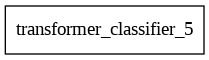

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(transformer, to_file="model_diagram.png", show_shapes=True, show_layer_names=True)

# Training

It's time to prepare the model and start training it.

### Set up the optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [ ]:
# Define the learning rate scheduler
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)  # Ensure d_model is a float
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)  # Ensure warmup_steps is a float

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Cast step to float32 to ensure compatibility
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        # Ensure division by sqrt of d_model
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            "d_model": self.d_model.numpy(),  # Return python float
            "warmup_steps": self.warmup_steps.numpy()  # Return python float
        }



### Set up the loss and metrics

In [ ]:
#updated
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)


# Instantiate the optimizer
#optimizer = tf.keras.optimizers.Adam(learning_rate=CustomSchedule(d_model=100),
                                     #beta_1=0.9, beta_2=0.98, epsilon=1e-9)



Test the custom learning rate scheduler:

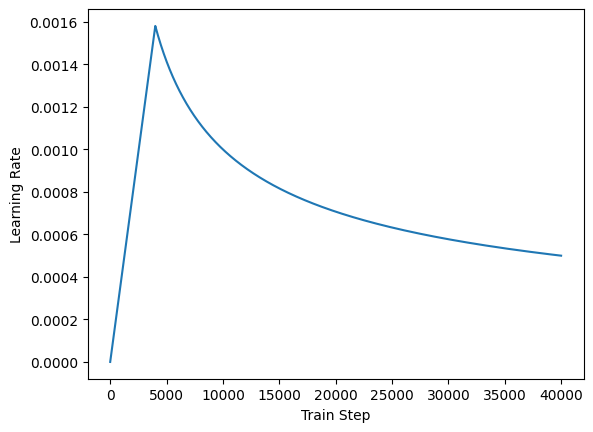

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.savefig(checkpoint_dir+'learning_rate_plot.png')

Instantiate the optimizer (in this example it's `tf.keras.optimizers.Adam`):

With all the components ready, configure the training procedure using `model.compile`, and then run it with `model.fit`:

Note: This takes about an hour to train in Colab.

##Save best model

In [ ]:

checkpoint_filepath = checkpoint_dir +model_base_name +'.{epoch:02d}-{val_accuracy:.2f}'
checkpoint_filepath

'./Final_Work/lp_plus_attn_enh_cl_more_lp_tx_2h_2l_tweet_emb_d06_dff256_ep12/lp_plus_attn_cl_enh_more_dat_tx_w_tweet_2h12l_ep12_d06_dff256.{epoch:02d}-{val_accuracy:.2f}'

In [ ]:
from keras import losses


callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath, #checkpoint_filepath define earlier in this notebook
        monitor="val_loss", #'val_loss'
        save_best_only=False,
        save_weights_only=True,  # Add this line
    )
]


####Compile the Model

In [ ]:

transformer.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
    run_eagerly=True)

# Compile model
#model2.compile(
#    loss='binary_crossentropy',
#    optimizer=optimizer,
#    metrics=['accuracy'],
#    run_eagerly=False)

# Define checkpointing
#checkpoint_dir = './model_checkpoints/'
#checkpoint_filepath = checkpoint_dir + 'tx_w_embeddings_cl2.{epoch:02d}-{val_accuracy:.2f}'

#callbacks_list = [
#    tf.keras.callbacks.ModelCheckpoint(
#        filepath=checkpoint_filepath,
#        monitor="val_loss",
#        save_best_only=True,
#        save_weights_only=True,
#    )]



####Start Training

Epoch 1/12
108/108 [==============================] - 29s 272ms/step - loss: 0.7671 - accuracy: 0.5328 - val_loss: 0.6197 - val_accuracy: 0.6969
Epoch 2/12
108/108 [==============================] - 30s 273ms/step - loss: 0.6522 - accuracy: 0.6386 - val_loss: 0.5234 - val_accuracy: 0.7625
Epoch 3/12
108/108 [==============================] - 29s 271ms/step - loss: 0.5924 - accuracy: 0.6868 - val_loss: 0.5034 - val_accuracy: 0.7493
Epoch 4/12
108/108 [==============================] - 29s 271ms/step - loss: 0.5577 - accuracy: 0.7211 - val_loss: 0.5025 - val_accuracy: 0.7651
Epoch 5/12
108/108 [==============================] - 29s 271ms/step - loss: 0.5317 - accuracy: 0.7409 - val_loss: 0.5156 - val_accuracy: 0.7362
Epoch 6/12
108/108 [==============================] - 29s 270ms/step - loss: 0.5211 - accuracy: 0.7470 - val_loss: 0.4583 - val_accuracy: 0.7992
Epoch 7/12
108/108 [==============================] - 29s 270ms/step - loss: 0.4892 - accuracy: 0.7749 - val_loss: 0.4386 - val_ac

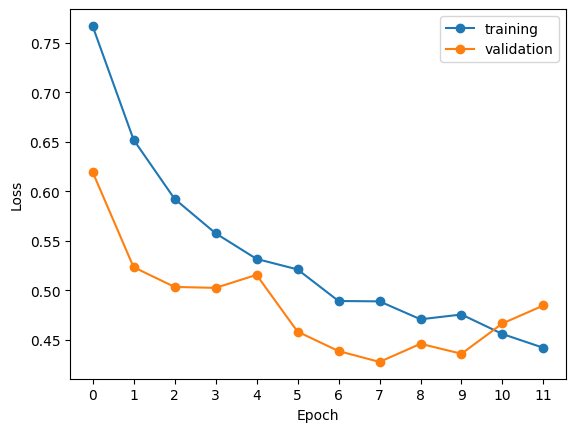

In [ ]:
history = transformer.fit(train_dataset, epochs=12, validation_data=val_dataset, callbacks=callbacks_list)

# Convert the return value into a DataFrame so we can see the train loss
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
plot_history(history, checkpoint_dir)
history_to_csv(history, num_layers, d_model, num_heads, dff, dropout_rate, model_base_name, load_data, checkpoint_dir, path_to_embeddings)


#Memory Clean Up

In [ ]:
del transformer

In [ ]:
note = "first one to return attention weights. Using d_type 256 and d =0.6\
baseline model. best val acc was  val_accuracy: 0.8215"

add a note to share drive

In [ ]:




# Define the directory and file name
directory = checkpoint_dir




readme_content = f"""Post Results Note: {note}

"""
# path
readme_file_path = f'{directory}/note_about_results.txt'

# Write the readme content to the file
with open(readme_file_path, 'w') as readme_file:
    readme_file.write(readme_content)

# Print a success message
print(f"The note_about_resultsfile has been successfully written to the '{directory}' directory.")

print(readme_content)

The note_about_resultsfile has been successfully written to the './Final_Work/lp_plus_attn_enh_cl_more_lp_tx_2h_2l_tweet_emb_d06_dff256_ep12/' directory.
Post Results Note: first one to return attention weights. Using d_type 256 and d =0.6baseline model. best val acc was  val_accuracy: 0.8215




#End of File